In [1]:
ROOT_DIR = './'

In [2]:
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="0000:01:00.0"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#ประกาศ Lib ที่จำเป็น
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import os
import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import pandas as pd
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log
leaf_DIR = os.path.join(ROOT_DIR, "dataSet")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [3]:
#เป็นการสร้าง class เพื่อทำ config ใช้สำหรับการ Train
class coinConfig(Config):
    NAME = "rice"
    
#เป็นการกำหนด Batch size มีค่าเท่ากับ (GPUs * images/GPU)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
#เป็นการกำหนดจำนวน class ให้รวม background ไปด้วย
    NUM_CLASSES = 1 + 1  #background + 1
    
#กำหนดขนาดของรูปที่ใช้ Train และ Test
# Input image resizing
    # Generally, use the "square" resizing mode for training and predicting
    # and it should work well in most cases. In this mode, images are scaled
    # up such that the small side is = IMAGE_MIN_DIM, but ensuring that the
    # scaling doesn't make the long side > IMAGE_MAX_DIM. Then the image is
    # padded with zeros to make it a square so multiple images can be put
    # in one batch.
    # Available resizing modes:
    # none:   No resizing or padding. Return the image unchanged.
    # square: Resize and pad with zeros to get a square image
    #         of size [max_dim, max_dim].
    # pad64:  Pads width and height with zeros to make them multiples of 64.
    #         If IMAGE_MIN_DIM or IMAGE_MIN_SCALE are not None, then it scales
    #         up before padding. IMAGE_MAX_DIM is ignored in this mode.
    #         The multiple of 64 is needed to ensure smooth scaling of feature
    #         maps up and down the 6 levels of the FPN pyramid (2**6=64).
    # crop:   Picks random crops from the image. First, scales the image based
    #         on IMAGE_MIN_DIM and IMAGE_MIN_SCALE, then picks a random crop of
    #         size IMAGE_MIN_DIM x IMAGE_MIN_DIM. Can be used in training only.
    #         IMAGE_MAX_DIM is not used in this mode.
    #IMAGE_RESIZE_MODE = "none"
    IMAGE_RESIZE_MODE = "square"
    
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
#เป็นการตั้งต่าในการเรียนรู้ต่อรอบการ Train แล้วเราจะหาตัวเลขที่เหมาะสมได้อย่างไร? จากรูปด้านล่างครับ
    STEPS_PER_EPOCH = 60
    
#step ของการตรวจสอบ
    VALIDATION_STEPS = 10
#เพิ่มจำนวน detection ในการตรวจจับ
    DETECTION_MAX_INSTANCES =1000
# Non-max suppression threshold to filter RPN proposals.
# You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7
# Non-max suppression threshold to filter RPN proposals.
# You can increase this during training to generate more propsals.
    DETECTION_NMS_THRESHOLD = 0.3
#ใช้ BACKBONE เป็น resnet101
    BACKBONE = 'resnet101'

    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9

config = coinConfig()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1000
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCE

In [4]:
#สร้าง class เพื่อจัดการ dataset
class riceDataset(utils.Dataset):
    def load_data(self, dataset_dir, subset):
        # Add classes. We have only one class to add.
        self.add_class("rice", 1, "rice")
        
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "rice",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "rice":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

In [9]:
annotations = json.load(open('dataSet/val/via_region_data.json'))
dataset_val = riceDataset()
dataset_val.load_data(leaf_DIR, 'val')
dataset_val.prepare()
class InferenceConfig(coinConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 1024
    DETECTION_MIN_CONFIDENCE = 0.9
    

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_rice_0059.h5")
#model_path = model.find_last()

#model_path = "D:\tensorflow1.13\logs\mask_rcnn_rice_0059.h5"
#model_path = COCO_MODEL_PATH

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

import skimage

Loading weights from  ./mask_rcnn_rice_0059.h5








In [20]:
cd  

D:\tensorflow1.13


D://tensorflow1.13//dataSet//Easy//1.jpg
Processing 1 images
image                    shape: (4624, 3468, 3)       min:    2.00000  max:  232.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  108.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4624.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


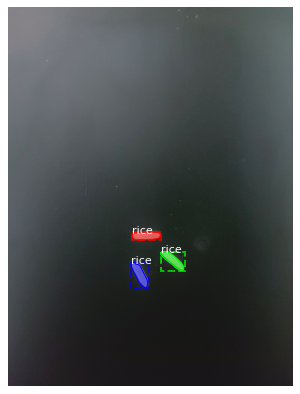

3


In [24]:
image_path= 'D://tensorflow1.13//dataSet//Easy//1.jpg'
print(image_path)
count = 0
img = skimage.io.imread(image_path)
img_arr = np.array(img)
results = model.detect([img_arr], verbose=1)
r = results[0]
final_score = np.squeeze(r['scores'])
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names,figsize=(7,7))
try: 
   for i in range(1000):
      if r['masks'] is None or final_score[i] > 0.5:
            count = count + 1
except:
    print(count)
count = 0